In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mlp
import scipy.linalg
import scipy.io
import pickle
import sys
import copy
import matplotlib.colors as colors
import seaborn as sns
import os
import array
import pandas
import random
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_scaled_W(W,totalInputs):
  """
  :param W:
      mxm Weight matrix
  :totalInputs:
      mx1 vector of the total inputs to each node
  """
  for i in range(W.shape[0]):
    if totalInputs[i] > 0:
        W[i,:] = W[i,:] / totalInputs[i]
  return W

def sort_eigs(y,v):
    neig = np.shape(y)[0]
    tmp2 = np.zeros(neig,dtype=np.complex)
    for i in range(neig):
        for j in range(i+1,neig):
            if np.real(y[j]) > np.real(y[i]):
                tmp = y[i]
                y[i] = y[j]
                y[j] = tmp
                tmp2[:] = v[:,i]
                v[:,i] = v[:,j]
                v[:,j] = tmp2[:]
    return y,v

def get_rand_W(connMatrix,cdf,totalInputs):
  """
  :param connMatrix:
      mxm Weight matrix/connectivity matrix
  :cdf:
      data structure with the list of all cell classes
  :totalInputs:
      mx1 vector of the sum of total inputs to each node.
  """
  W = abs(connMatrix)
  fp = 1.0 - 0.86 # false positive rate
  fn = 0.86/0.83 - 0.86 # false negative rate
  false_negatives = np.zeros(np.shape(W))
  post_blocks = [np.where(cdf.loc['integ'])[0],
                np.where(cdf.loc['vest'])[0],
                np.where(cdf.loc['abdm'])[0],
                np.where(cdf.loc['abdi'])[0]]
  pre_blocks = [np.where(cdf.loc['integ'])[0],
              np.where(cdf.loc['vest'])[0]]
  for pob in post_blocks:
    for prb in pre_blocks:
        stot = int(np.sum(W[np.ix_(pob,prb)]))
        rolls = np.random.rand(stot)
        pre = np.random.choice(prb,stot)
        post = np.random.choice(pob,stot)
        for i in range(stot):
            if rolls[i] < fn:
                false_negatives[post[i],pre[i]] += 1
  stot = np.zeros(W.shape[0])
  for i in range(W.shape[0]):
    add_rolls = np.random.rand(totalInputs[i] - int(np.sum(W[i,:])))
    sub_rolls = np.random.rand(totalInputs[i] - int(np.sum(W[i,:])))
    stot[i] = totalInputs[i] + np.sum(add_rolls < fn) - np.sum(sub_rolls < fp)
    for j in range(W.shape[0]):
        rolls = np.random.rand(int(W[i,j]))
        false_positives = np.sum(rolls < fp)
        W[i,j] = W[i,j] - false_positives
        stot[i] = stot[i] - false_positives
  W = W + false_negatives
  for i in range(W.shape[0]):
    if stot[i] > 0:
        W[i,:] = W[i,:] / np.float16(stot[i])
  W[:,cdf.loc['vest']] = - W[:,cdf.loc['vest']]
  return W

def get_slopes(W):
    """
    :param W:
        mxm Weight matrix
    :return:
        mx1 returns the firing rate of the neurons
    """
    y,v = np.linalg.eig(W)
    y,v = sort_eigs(y,v)
    scaled_W = W / np.real(y[0])

    # #W[:,[101,151,104,166,100,103,104]] = 0
    # for num in args:
    #    W[:,num] = 0

    v_int = np.real(v[:,0])
    if np.sum(v_int) < 0:
        v_int = -v_int
    input_filter = 0.001*np.exp(-np.linspace(0,10,101))
    I = np.zeros(3000)
    I[995:1005] = 1e5
    I = np.convolve(I,input_filter)[0:3000]
    r = np.zeros(W.shape[0])
    dt = 0.001
    tau = 0.1
    for i in range(1,3000):
        r = r + dt*(np.dot(scaled_W,r) - r + I[i-1]*v_int)/tau
        #r = r * (r > 0)
    return r, scaled_W

def get_Kvalues(connMatName, totalInputsName, cellIDsName, *args, **kwargs):

  """
  *args: indices to columns that need to be zeroed.

  """
  dir_name = '/content/drive/My Drive/Colab Notebooks/Kvalues/'
  filename_suffix = 'mat'

  # load connectivity matrix

  connMatFile  =  os.path.join(dir_name, connMatName + "." + filename_suffix)
  connMat = scipy.io.loadmat(connMatFile)
  connMatDict = list(connMat)
  connMat = np.float16(connMat[connMatDict[-1]])
  np.fill_diagonal(connMat,0)

  # load total inputs onto the cells

  totalInputFile = os.path.join(dir_name, totalInputsName + "." + filename_suffix)
  totalInputs = scipy.io.loadmat(totalInputFile)
  totalInputsDict = list(totalInputs)
  totalInputs = np.int32(totalInputs[totalInputsDict[-1]])
  totalInputs = np.ravel(totalInputs)

  # load cellIDs
  cellIDFile  = os.path.join(dir_name, cellIDsName + "." + filename_suffix)
  cellIDs = scipy.io.loadmat(cellIDFile)
  cellIDFileDict = list(cellIDs)
  cellIDs = cellIDs[cellIDFileDict[-1]]
  cellIDs_unique = set(cellIDs)

  # get location of neurons
  cellLocations =  np.array([(cellIDs == '_Int_'),(cellIDs == 'Ibn_m'),(cellIDs == 'Ibn_i'),(cellIDs == '_MOs_'),
                             (cellIDs == '_Axlm'), (cellIDs == '_Axl_'), (cellIDs == '_DOs_'),(cellIDs == 'ABD_m'),
                             (cellIDs == 'ABD_i'), (cellIDs == 'vSPNs')])
  
  cellNames = ('integ','Ibnm','Ibni','MO','axlm','axl','vest','abdm','abdi','vspns')

  cdf = pandas.DataFrame(cellLocations,cellNames)

  # make DOs negative
  connMat[:,cdf.loc['vest']] = -connMat[:,cdf.loc['vest']]
  connMat[:,cdf.loc['MO']] = -connMat[:,cdf.loc['MO']]

  # set ABD,vSPNs outgoing to 0
  connMat[:,cdf.loc['abdm']] = 0
  connMat[:,cdf.loc['abdi']] = 0
  connMat[:,cdf.loc['vspns']] = 0

  # set IBN outgoing to 0
  connMat[:,cdf.loc['Ibni']] = 0
  connMat[:,cdf.loc['Ibnm']] = 0

  # make Axial modules 0
  connMat[:,cdf.loc['axl']] = 0
  connMat[cdf.loc['axl'],:] = 0

  connMat[:,cdf.loc['axlm']] = 0
  connMat[cdf.loc['axlm'],:] = 0

  # variable population ##
  if 'sign' in kwargs:
    for num in args:
      #num
      connMat[:,num] = -connMat[:,num]
  else:
    for num in args:
      connMat[:,num] = 0


  # normalize W matrix by total inputs

  Wnorm = np.zeros(connMat.shape)
  tempMat = np.copy(connMat)
  for i in np.arange(connMat.shape[0]):
    if totalInputs[i]>0:
      Wnorm[i,:] = tempMat[i,:] / totalInputs[i,None]

  # Wnorm = connMat / totalInputs[:,None] # normalize by all inputs
  # Wnorm = np.nan_to_num(Wnorm) # replace nans with 0

 # call funciton
  slopes,scaled_W = get_slopes(Wnorm) 

  sf = 2.574 / np.mean(slopes[cdf.loc['integ']]) # 2.574 is the mean GF_VPNI Kvalues from literature
  slopes = sf*slopes

  return slopes,cdf,connMat,cellIDs,scaled_W


######## Make Plots ##########

def draw_matrix(connMat,cellIDs):
  connMat_T = connMat
  #connMat_T[connMat_T>3] = 3

  lines = []
  for i in range(cellIDs.shape[0]):
    if cellIDs[i-1]!= cellIDs[i]:
      lines.append(i)

  ax = sns.heatmap(connMat_T,cmap='seismic_r',square='True',center=0, xticklabels=20, yticklabels=False)
  plt.hlines(lines,xmin=0,xmax=connMat_T.shape[0],lw = 0.5)
  plt.vlines(lines,ymin=0,ymax=connMat_T.shape[0],lw = 0.5)
  return ax

def draw_box(slopes,cdf):
  sns.boxplot(data = (slopes[cdf.loc['integ']],slopes[cdf.loc['vest']],slopes[cdf.loc['abdm']],slopes[cdf.loc['abdi']]),palette="Set2", meanline = True);
  plt.xticks([0,1,2,3], labels=['integ','vest','abdm','abdi'], rotation = 45)
  #plt.ylim([0,15])
  plt.grid()
  #plt.tight_layout()

def draw_plot(slopes,cdf):
  integ_data = slopes[cdf.loc['integ']]
  # low = np.percentile(integ_data,1.0)
  # high = np.percentile(integ_data,99)
  # integ_data = integ_data[((integ_data > low) & (integ_data < high))]

  vest_data = slopes[cdf.loc['vest']]
  # low = np.percentile(vest_data,1.0)
  # high = np.percentile(vest_data,99)
  # vest_data = vest_data[((vest_data > low) & (vest_data < high))]

  abdm_data = slopes[cdf.loc['abdm']]
  # low = np.percentile(abdm_data,1.0)
  # high = np.percentile(abdm_data,99)
  # abdm_data = abdm_data[((abdm_data > low) & (abdm_data < high))]

  abdi_data = slopes[cdf.loc['abdi']]
  # low = np.percentile(abdi_data,1.0)
  # high = np.percentile(abdi_data,99)
  # abdi_data = abdi_data[((abdi_data > low) & (abdi_data < high))]

  plt.errorbar([1,2,3,4],[np.mean(integ_data),np.mean(vest_data),np.mean(abdm_data),np.mean(abdi_data)],
          yerr = [np.std(integ_data)/np.sqrt(np.sum(cdf.loc['integ']==True)),
                  np.std(vest_data)/np.sqrt(np.sum(cdf.loc['vest']==True)),
                  np.std(abdm_data)/np.sqrt(np.sum(cdf.loc['abdm']==True)),
                  np.std(abdi_data)/np.sqrt(np.sum(cdf.loc['abdi']==True))],
              Marker = 'o')

def draw_hist(slopes,cdf):
  sns.distplot(slopes[cdf.loc['integ']],kde=False,label='integ',color='blue')
  sns.distplot(slopes[cdf.loc['vest']],kde=False,label = 'vest',color='orange')
  sns.distplot(slopes[cdf.loc['abdm']],kde=False,label ='abdm',color = 'green')
  sns.distplot(slopes[cdf.loc['abdi']],kde=False,label ='abdi', color = 'magenta')

def draw_violin(slopes,cdf,variations_included=False):
  if variations_included:
    nruns = np.shape(slopes)[0]
    integ_data = np.reshape(slopes[:,cdf.loc['integ']],(255*nruns,))
    low = np.percentile(integ_data,0.3)
    high = np.percentile(integ_data,99.7)
    integ_data = integ_data[((integ_data > low) & (integ_data < high))]
    vest_data = np.reshape(slopes[:,cdf.loc['vest']],(34*nruns,))
    low = np.percentile(vest_data,0.3)
    high = np.percentile(vest_data,99.7)
    vest_data = vest_data[((vest_data > low) & (vest_data < high))]
    abdm_data = np.reshape(slopes[:,cdf.loc['abdm']],(32*nruns,))
    low = np.percentile(abdm_data,0.3)
    high = np.percentile(abdm_data,99.7)
    abdm_data = abdm_data[((abdm_data > low) & (abdm_data < high))]
    abdi_data = np.reshape(slopes[:,cdf.loc['abdi']],(22*nruns,))
    low = np.percentile(abdi_data,0.3)
    high = np.percentile(abdi_data,99.7)
    abdi_data = abdi_data[((abdi_data > low) & (abdi_data < high))]
    sns.violinplot(data  = (integ_data,vest_data,abdm_data,abdi_data),
                   bw=0.2, linewidth = 1, scale = 'area',palette="Set2");
  else:
    integ_data = slopes[cdf.loc['integ']]
    vest_data = slopes[cdf.loc['vest']]
    abdm_data = slopes[cdf.loc['abdm']]
    abdi_data = slopes[cdf.loc['abdi']]
    sns.violinplot(data  = (integ_data,vest_data,abdm_data,abdi_data),
                   bw=0.2, linewidth = 1, scale = 'area',palette="Set2");

def get_synapseID_error(slopes,cdf):
  errs = []
  nruns = np.shape(slopes)[0]
  errs.append(np.sqrt(np.var(np.mean(slopes[:,cdf.loc['vest']],axis=1))/nruns))
  errs.append(np.sqrt(np.var(np.mean(slopes[:,cdf.loc['integ']],axis=1))/nruns))
  errs.append(np.sqrt(np.var(np.mean(slopes[:,cdf.loc['abdm']],axis=1))/nruns))
  errs.append(np.sqrt(np.var(np.mean(slopes[:,cdf.loc['abdi']],axis=1))/nruns))
  return errs

def draw_compare(slopes,cdf,sid_err=[0,0,0,0]):
  k_pred = np.zeros(4)
  k_pred_err = np.zeros(4)
  k_meas_primate = np.zeros(3)
  k_meas_err_primate = np.zeros(3)
  k_meas_cat = np.zeros(2)
  k_meas_err_cat = np.zeros(2)
  k_meas_goldfish = np.zeros(4)
  k_meas_err_goldfish = np.zeros(4)

  pred_x = [1,10,20,30]
  primate_x = [11,21,31]
  cat_x = [22,32]
  goldfish_x = [3,13,23,33]

  plotOrder = ('Vestibular','Integrator','Motoneurons','Internuclear')

  # model means
  k_pred[0] = np.mean(slopes[cdf.loc['vest']])
  k_pred_err[0] = np.std(slopes[cdf.loc['vest']])/np.sqrt(np.sum(cdf.loc['vest']))
  k_pred_err[0] = np.sqrt(k_pred_err[0]**2 + sid_err[0]**2)
  k_pred[1] = np.mean(slopes[cdf.loc['integ']]) 
  k_pred_err[1] = np.std(slopes[cdf.loc['integ']]) / np.sqrt(np.sum(cdf.loc['integ']))
  k_pred_err[1] = np.sqrt(k_pred_err[1]**2 + sid_err[1]**2)
  k_pred[2] = np.mean(slopes[cdf.loc['abdm']])
  k_pred_err[2] = np.std(slopes[cdf.loc['abdm']]) / np.sqrt(np.sum(cdf.loc['abdm']))
  k_pred_err[2] = np.sqrt(k_pred_err[2]**2 + sid_err[2]**2)
  k_pred[3] = np.mean(slopes[cdf.loc['abdi']])
  k_pred_err[3] = np.std(slopes[cdf.loc['abdi']]) / np.sqrt(np.sum(cdf.loc['abdi']))
  k_pred_err[3] = np.sqrt(k_pred_err[3]**2 + sid_err[3]**2)

  # goldfish 
  k_meas_goldfish[0] = 0.17
  k_meas_err_goldfish[0] = 0.02
  k_meas_goldfish[1] = 2.8
  k_meas_err_goldfish[1] = 2.8*.205
  k_meas_goldfish[2] = (7.13*12 + 6.32*10) / 22
  k_meas_err_goldfish[2] = math.sqrt(3.4**2/12 + 1.4**2/10) / 2
  k_meas_err_goldfish[3] = 1.71 / math.sqrt(19)
  k_meas_goldfish[3] = 8.37

  # cat
  k_meas_cat[0] = (8.7*40 + 51*3.13 + 104*6.17) / 205
  k_meas_err_cat[0] = math.sqrt(2.5**2/40 + 0.15**2 + 0.19**2) / 3
  k_meas_cat[1] = 12.41
  k_meas_err_cat[1] = 2.91 / math.sqrt(10)

  # primate
  k_meas_primate[0] = (51*3.2 + 19*2.4 + 14*1.5) / 84
  k_meas_err_primate[0] = math.sqrt(1.3**2/51 + 1.6**2/19 + 1.1**2/14) / 3
  k_meas_primate[1] = 6.2
  k_meas_err_primate[1] = 3.09 / math.sqrt(81)
  k_meas_primate[2] = 4.6
  k_meas_err_primate[2] = 1.5 / math.sqrt(36)

  #plot
  plt.errorbar(pred_x,k_pred,yerr=k_pred_err,fmt='o',color='k',label='Model prediction')
  plt.errorbar(primate_x,k_meas_primate,yerr=k_meas_err_primate,fmt='v',color='r',label='Macaque')
  plt.errorbar(cat_x,k_meas_cat,yerr=k_meas_err_cat,fmt='s',color='b',label='Cat')
  plt.errorbar(goldfish_x,k_meas_goldfish,yerr=k_meas_err_goldfish,fmt='d',color='g',label='Goldfish')
  plt.xticks([2,12,22,32],('Vestibular','Integrator','Motoneurons','Internuclear'),rotation = 45)
  plt.ylabel('$k$ (spikes/s/deg)')
  plt.grid()
  plt.tight_layout()
  l = plt.legend()
  return 

In [ ]:
dir_name = '/content/drive/My Drive/Colab Notebooks/Kvalues/'
filename_suffix = 'mat'
totalInputsName = 'TotalSynapsesPot_5'
totalInputFile = os.path.join(dir_name, totalInputsName + "." + filename_suffix)
totalInputs = scipy.io.loadmat(totalInputFile)
totalInputsDict = list(totalInputs)
totalInputs = np.int32(totalInputs[totalInputsDict[-1]])
totalInputs = np.ravel(totalInputs)

In [ ]:
slopes_CO_top500_2blocks,cdf_CO_top500_2blocks,connMat_CO_top500_2blocks,cellIDs_CO_top500_2blocks,connMat_CO_top500_scaled_2blocks = get_Kvalues('ConnMatrix_CO_top500_2blocks_gamma038_08062020','totalInputs_CO_top500_2blocks_gamma038_08062020','cellIDType_CO_top500_2blocks_gamma038_08062020')
#slopes_CO_top500_2blocks_unscaled,cdf_CO_top500_2blocks,_,_,_ = get_Kvalues('ConnMatrix_CO_top500_2blocks_gamma038_08062020','totalInputs_CO_top500_2blocks_gamma038_08062020','cellIDType_CO_top500_2blocks_gamma038_08062020','',scale = "unscaled")

In [ ]:
slopes_CO_top500_2blocks_pot2,cdf_CO_top500_2blocks_pot2,connMat_CO_top500_2blocks_pot2,cellIDs_CO_top500_2blocks_pot2,connMat_CO_top500_scaled_2blocks_pot2 = get_Kvalues('PotentialConnectome_22_2','TotalSynapsesPot_2','cellIDType_block2_potSynapse')
slopes_CO_top500_2blocks_pot5,cdf_CO_top500_2blocks_pot5,connMat_CO_top500_2blocks_pot5,cellIDs_CO_top500_2blocks_pot5,connMat_CO_top500_scaled_2blocks_pot5 = get_Kvalues('PotentialConnectome_22_5','TotalSynapsesPot_5','cellIDType_block2_potSynapse')
slopes_CO_top500_2blocks_pot10,cdf_CO_top500_2blocks_pot10,connMat_CO_top500_2blocks_pot10,cellIDs_CO_top500_2blocks_pot10,connMat_CO_top500_scaled_2blocks_pot10 = get_Kvalues('PotentialConnectome_22_10','TotalSynapsesPot_10','cellIDType_block2_potSynapse')

([<matplotlib.axis.XTick at 0x7f7b2c8b7080>,
 [Text(0, 0, 'Int'),
  Text(0, 0, 'Vest'),
  Text(0, 0, 'ABDm'),
  Text(0, 0, 'ABDi')])

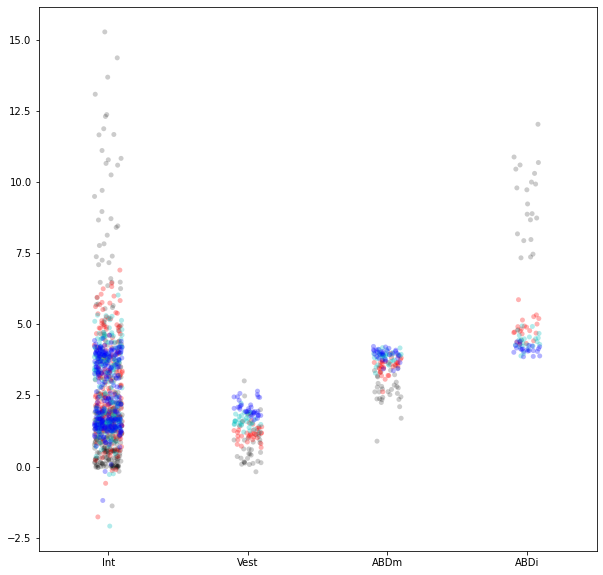

In [ ]:
plt.figure(figsize=[10,10])
sns.stripplot(  data = (slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['integ']],
                       slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['vest']],
                       slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['abdm']],
                       slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['abdi']]), color = 'k',alpha = 0.2,label = 'true')

sns.stripplot( data = (slopes_CO_top500_2blocks_pot2[cdf_CO_top500_2blocks_pot2.loc['integ']],
                       slopes_CO_top500_2blocks_pot2[cdf_CO_top500_2blocks_pot2.loc['vest']],
                       slopes_CO_top500_2blocks_pot2[cdf_CO_top500_2blocks_pot2.loc['abdm']],
                       slopes_CO_top500_2blocks_pot2[cdf_CO_top500_2blocks_pot2.loc['abdi']]), color = 'r', alpha =0.3,label = '2um')


sns.stripplot( data = (slopes_CO_top500_2blocks_pot5[cdf_CO_top500_2blocks_pot5.loc['integ']],
                       slopes_CO_top500_2blocks_pot5[cdf_CO_top500_2blocks_pot5.loc['vest']],
                       slopes_CO_top500_2blocks_pot5[cdf_CO_top500_2blocks_pot5.loc['abdm']],
                       slopes_CO_top500_2blocks_pot5[cdf_CO_top500_2blocks_pot5.loc['abdi']]), color = 'c', alpha =0.3)

sns.stripplot( data = (slopes_CO_top500_2blocks_pot10[cdf_CO_top500_2blocks_pot10.loc['integ']],
                       slopes_CO_top500_2blocks_pot10[cdf_CO_top500_2blocks_pot10.loc['vest']],
                       slopes_CO_top500_2blocks_pot10[cdf_CO_top500_2blocks_pot10.loc['abdm']],
                       slopes_CO_top500_2blocks_pot10[cdf_CO_top500_2blocks_pot10.loc['abdi']]), color = 'b', alpha =0.3)

#plt.legend()
plt.xticks([0,1,2,3], labels=['Int','Vest','ABDm','ABDi'])



([<matplotlib.axis.XTick at 0x7fa90cb1e2e8>,
 [Text(0, 0, 'Int'),
  Text(0, 0, 'Vest'),
  Text(0, 0, 'ABDm'),
  Text(0, 0, 'ABDi')])

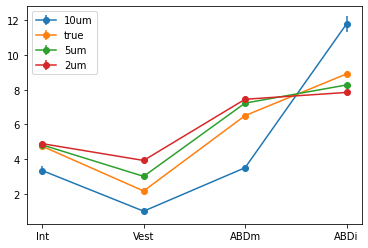

In [ ]:
draw_plot(slopes_CO_top500_2blocks,cdf_CO_top500_2blocks)
draw_plot(slopes_CO_top500_2blocks_pot2,cdf_CO_top500_2blocks_pot2)
draw_plot(slopes_CO_top500_2blocks_pot5,cdf_CO_top500_2blocks_pot5)
draw_plot(slopes_CO_top500_2blocks_pot10,cdf_CO_top500_2blocks_pot10)
plt.legend({'true','2um','5um','10um'})
plt.xticks([1,2,3,4], labels=['Int','Vest','ABDm','ABDi'])


In [ ]:
slope = slopes_CO_top500_2blocks_pot2
cdf = cdf_CO_top500_2blocks_pot2
slopes_dic = {"Kvalues": slope, "Int_pot2" : slope[cdf.loc['integ']],
                        "Vest_pot2" : slope[cdf.loc['vest']],
                       "ABDm_pot2" : slope[cdf.loc['abdm']],
                        "ABDi_pot2" : slope[cdf.loc['abdi']]}
scipy.io.savemat('/content/drive/My Drive/Colab Notebooks/Kvalues/slopes_CO_top500_unscaled_Pot_2.mat',slopes_dic)


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 57.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 68.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 73.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 74.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'abdi')

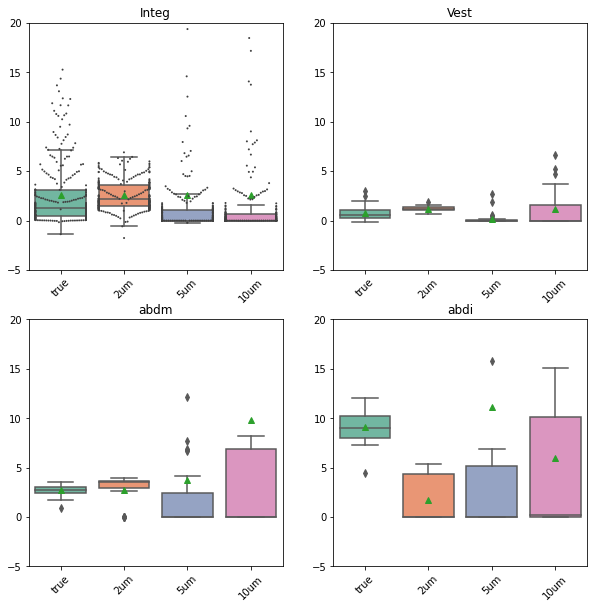

In [ ]:
plt.figure(figsize=[10,10])
plt.subplot(2,2,1)
sns.boxplot(data = (slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['integ']],
            slopes_CO_top500_2blocks_pot2[cdf_CO_top500_2blocks_pot2.loc['integ']],
            slopes_CO_top500_2blocks_pot5[cdf_CO_top500_2blocks_pot5.loc['integ']],
            slopes_CO_top500_2blocks_pot10[cdf_CO_top500_2blocks_pot10.loc['integ']]),
            palette="Set2",showmeans = True,showfliers = False);
sns.swarmplot(data = (slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['integ']],
            slopes_CO_top500_2blocks_pot2[cdf_CO_top500_2blocks_pot2.loc['integ']],
            slopes_CO_top500_2blocks_pot5[cdf_CO_top500_2blocks_pot5.loc['integ']],
            slopes_CO_top500_2blocks_pot10[cdf_CO_top500_2blocks_pot10.loc['integ']]),
            color=".25",size=2)
plt.xticks([0,1,2,3], labels=['true','2um','5um','10um'], rotation = 45)
plt.ylim([-5,20]) 
plt.title('Integ')    

plt.subplot(2,2,2)
sns.boxplot(data = (slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['vest']],
            slopes_CO_top500_2blocks_pot2[cdf_CO_top500_2blocks_pot2.loc['vest']],
            slopes_CO_top500_2blocks_pot5[cdf_CO_top500_2blocks_pot5.loc['vest']],
            slopes_CO_top500_2blocks_pot10[cdf_CO_top500_2blocks_pot10.loc['vest']]),palette="Set2",showmeans = True);
plt.xticks([0,1,2,3], labels=['true','2um','5um','10um'], rotation = 45)
plt.ylim([-5,20]) 
plt.title('Vest') 

plt.subplot(2,2,3)
sns.boxplot(data = (slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['abdm']],
            slopes_CO_top500_2blocks_pot2[cdf_CO_top500_2blocks_pot2.loc['abdm']],
            slopes_CO_top500_2blocks_pot5[cdf_CO_top500_2blocks_pot5.loc['abdm']],
            slopes_CO_top500_2blocks_pot10[cdf_CO_top500_2blocks_pot10.loc['abdm']]),palette="Set2",showmeans = True);
plt.ylim([-5,20])
plt.xticks([0,1,2,3], labels=['true','2um','5um','10um'], rotation = 45)
plt.title('abdm')

plt.subplot(2,2,4)
sns.boxplot(data = (slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['abdi']],
            slopes_CO_top500_2blocks_pot2[cdf_CO_top500_2blocks_pot2.loc['abdi']],
            slopes_CO_top500_2blocks_pot5[cdf_CO_top500_2blocks_pot5.loc['abdi']],
            slopes_CO_top500_2blocks_pot10[cdf_CO_top500_2blocks_pot10.loc['abdi']]),palette="Set2",showmeans = True);
plt.ylim([-5,20]) 
plt.xticks([0,1,2,3], labels=['true','2um','5um','10um'], rotation = 45)
plt.title('abdi')

Text(0.5, 1.0, 'abdi')

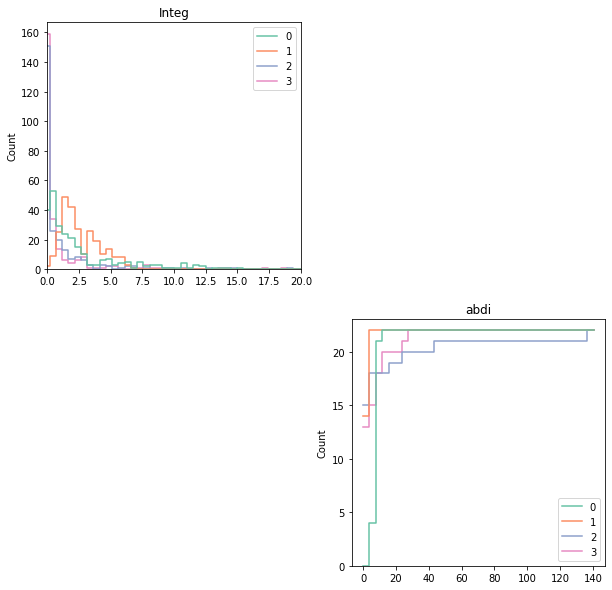

In [ ]:
plt.figure(figsize=[10,10])
plt.subplot(2,2,1)
sns.histplot(data = (slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['integ']],
            slopes_CO_top500_2blocks_pot2[cdf_CO_top500_2blocks_pot2.loc['integ']],
            slopes_CO_top500_2blocks_pot5[cdf_CO_top500_2blocks_pot5.loc['integ']],
            slopes_CO_top500_2blocks_pot10[cdf_CO_top500_2blocks_pot10.loc['integ']]),
            palette="Set2", element="step", fill=False, stat="count");
plt.xlim([0,20])
plt.title('Integ')


plt.subplot(2,2,4)
sns.histplot(data = (slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['abdi']],
                    slopes_CO_top500_2blocks_pot2[cdf_CO_top500_2blocks_pot2.loc['abdi']],
                     slopes_CO_top500_2blocks_pot5[cdf_CO_top500_2blocks_pot5.loc['abdi']],
                     slopes_CO_top500_2blocks_pot10[cdf_CO_top500_2blocks_pot10.loc['abdi']]),
             palette="Set2", element="step", fill=False, cumulative=True, stat="count", common_norm=False);
plt.title('abdi')

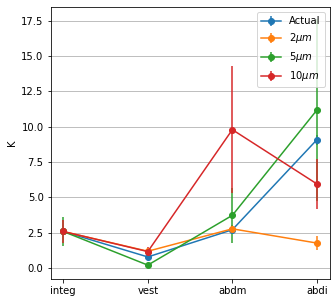

In [ ]:
plt.figure(figsize=[5,5])
draw_plot(slopes_CO_top500_2blocks,cdf_CO_top500_2blocks)
draw_plot(slopes_CO_top500_2blocks_pot2,cdf_CO_top500_2blocks_pot2)
draw_plot(slopes_CO_top500_2blocks_pot5,cdf_CO_top500_2blocks_pot5)
draw_plot(slopes_CO_top500_2blocks_pot10,cdf_CO_top500_2blocks_pot10)
plt.xticks([1,2,3,4], labels=['integ','vest','abdm','abdi'], rotation = 0);
plt.ylabel('K')
plt.legend(['Actual','$2\mu m$','$5\mu m$','$10\mu m$'])
plt.grid(axis='y',which= 'major')
#plt.savefig('/content/drive/My Drive/Colab Notebooks/Kvalues/PotentialSynapses.svg')

In [ ]:
slopes_CO_top500_dic = {"Kvalues": slopes_CO_top500_2blocks, "Int" : slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['integ']],
                        "Vest" : slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['vest']], "ABDm" : slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['abdm']],
                        "ABDi" : slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['abdi']]}
scipy.io.savemat('/content/drive/My Drive/Colab Notebooks/Kvalues/slopes_CO_top500_unscaled_08062020.mat',slopes_CO_top500_dic)

# slopes_CO_top500_unscaled_dic = {"Kvalues": slopes_CO_top500_2blocks_unscaled, "Int" : slopes_CO_top500_2blocks_unscaled[cdf_CO_top500_2blocks.loc['integ']],
#                         "Vest" : slopes_CO_top500_2blocks_unscaled[cdf_CO_top500_2blocks.loc['vest']], "ABDm" : slopes_CO_top500_2blocks_unscaled[cdf_CO_top500_2blocks.loc['abdm']],
#                         "ABDi" : slopes_CO_top500_2blocks_unscaled[cdf_CO_top500_2blocks.loc['abdi']]}
# scipy.io.savemat('/content/drive/My Drive/Colab Notebooks/Kvalues/slopes_CO_top500_unscaled_08062020.mat',slopes_CO_top500_unscaled_dic)

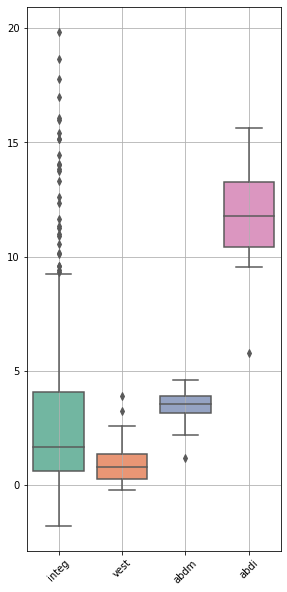

In [ ]:
plt.figure(figsize=[10,10])
plt.subplot(1,2,1)
draw_box(slopes_CO_top500_2blocks,cdf_CO_top500_2blocks)
# plt.subplot(1,2,2)
# draw_box(slopes_CO_top500_2blocks_unscaled,cdf_CO_top500_2blocks)

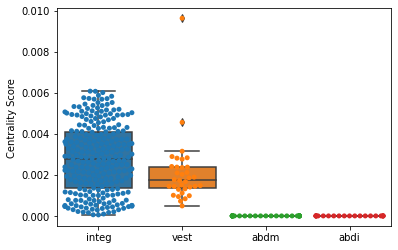

In [ ]:
centralityScore = 'CentralityScore_CO_top500_2blocks_gamma038_08062020'
dir_name = '/content/drive/My Drive/Colab Notebooks/Kvalues/'
filename_suffix = 'mat'
centralityScoreFile = os.path.join(dir_name, centralityScore + "." + filename_suffix)
centralityScore = scipy.io.loadmat(centralityScoreFile)
centralityScoreDict = list(centralityScore)
centralityScore = np.float16(centralityScore[centralityScoreDict[-1]])
centralityScore = np.ravel(centralityScore)

sns.swarmplot(data = (centralityScore[cdf_CO_top500_2blocks.loc['integ']],
                       centralityScore[cdf_CO_top500_2blocks.loc['vest']],
                       centralityScore[cdf_CO_top500_2blocks.loc['abdm']],
                       centralityScore[cdf_CO_top500_2blocks.loc['abdi']]))
sns.boxplot(data = (centralityScore[cdf_CO_top500_2blocks.loc['integ']],
                       centralityScore[cdf_CO_top500_2blocks.loc['vest']],
                       centralityScore[cdf_CO_top500_2blocks.loc['abdm']],
                       centralityScore[cdf_CO_top500_2blocks.loc['abdi']]))
plt.ylabel('Centrality Score')
plt.xticks([0,1,2,3], labels=['integ','vest','abdm','abdi'], rotation = 0);


Text(0, 0.5, 'VPNI K')

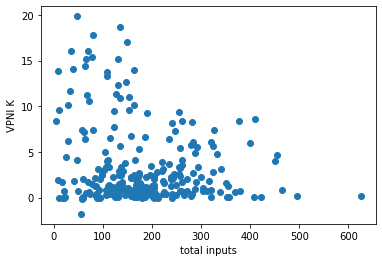

In [ ]:
totalInputs = 'totalInputs_CO_top500_2blocks_gamma038_08062020'
dir_name = '/content/drive/My Drive/Colab Notebooks/Kvalues/'
filename_suffix = 'mat'
totalInputFile = os.path.join(dir_name, totalInputs + "." + filename_suffix)
totalInputs = scipy.io.loadmat(totalInputFile)
totalInputsDict = list(totalInputs)
totalInputs = np.int16(totalInputs[totalInputsDict[-1]])
totalInputs = np.ravel(totalInputs)

plt.scatter(totalInputs[cdf_CO_top500_2blocks.loc['integ']],slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['integ']])
plt.xlabel('total inputs')
plt.ylabel('VPNI K')


In [ ]:
nruns = 1000;
# run many times with random variations around measured matrix
slopes_many = np.zeros((nruns,connMat_CO_top500_2blocks.shape[0]))
for i in range(nruns):
    #W = get_rand_W(get_scaled_W(connMat_CO_top500_2blocks,totalInputs),cdf_CO_top500_2blocks,totalInputs)
    W = get_rand_W(connMat_CO_top500_2blocks,cdf_CO_top500_2blocks,totalInputs)
    [slopes_many[i,:],_] = get_slopes(W)

# sf = 2.8 / np.mean(slopes_many[:,cdf_CO_top500_2blocks.loc['integ']])
# slopes_many = sf*slopes_many

In [ ]:
plt.subplot(1,2,1)
draw_violin(slopes_many,cdf_CO_top500_2blocks,True)
#sns.violinplot(data = (np.concatenate(slopes_many[:,cdf_CO_top500_2blocks.loc['integ']]),
        np.concatenate(slopes_many[:,cdf_CO_top500_2blocks.loc['vest']]),
        np.concatenate(slopes_many[:,cdf_CO_top500_2blocks.loc['abdm']]),
        np.concatenate(slopes_many[:,cdf_CO_top500_2blocks.loc['abdi']])), bw=0.2,
         linewidth = 1, scale = 'area',palette="Set2", cut = 0)
plt.title('1000 runs with noise')
plt.xticks([0,1,2,3], labels=['integ','vest','abdm','abdi'], rotation = 0);

plt.subplot(1,2,2)
draw_violin(slopes_many,cdf_CO_top500_2blocks,True)
#sns.violinplot(data = (np.concatenate(slopes_many[:,cdf_CO_top500_2blocks.loc['integ']]),
        np.concatenate(slopes_many[:,cdf_CO_top500_2blocks.loc['vest']]),
        np.concatenate(slopes_many[:,cdf_CO_top500_2blocks.loc['abdm']]),
        np.concatenate(slopes_many[:,cdf_CO_top500_2blocks.loc['abdi']])), bw=0.2, linewidth = 1, scale = 'area',palette="Set2")
plt.ylim([0,20])
plt.title('Y-axis clipped [0,20]')
plt.xticks([0,1,2,3], labels=['integ','vest','abdm','abdi'], rotation = 0);

IndentationError: ignored

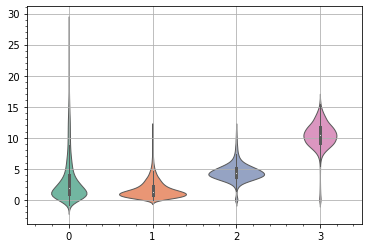

In [ ]:
draw_violin(slopes_many,cdf_CO_top500_2blocks,variations_included=True)
plt.minorticks_on()
plt.grid(which='major')

In [ ]:
slopes_many_CO_top500_dic = {"Kvalues": slopes_many, "Int" : slopes_many[:,cdf_CO_top500_2blocks.loc['integ']],
                        "Vest" : slopes_many[:,cdf_CO_top500_2blocks.loc['vest']], "ABDm" : slopes_many[:,cdf_CO_top500_2blocks.loc['abdm']],
                        "ABDi" : slopes_many[:,cdf_CO_top500_2blocks.loc['abdi']]}
scipy.io.savemat('/content/drive/My Drive/Colab Notebooks/Kvalues/slopes_many_CO_top500_unscaled_08062020.mat',slopes_many_CO_top500_dic)

Text(0.5, 1.0, 'Xaxis clipped at [0,20]')

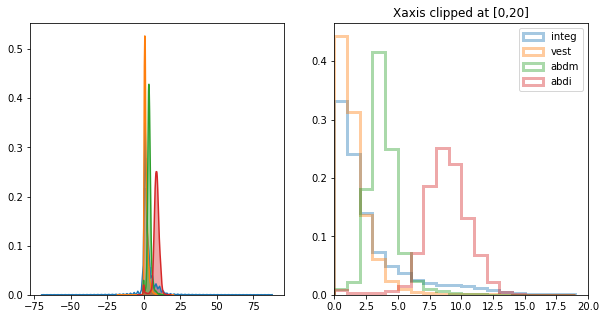

In [ ]:
plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
sns.distplot(slopes_many[:,cdf_CO_top500_2blocks.loc['integ']], norm_hist=True)
sns.distplot(slopes_many[:,cdf_CO_top500_2blocks.loc['vest']], norm_hist=True)
sns.distplot(slopes_many[:,cdf_CO_top500_2blocks.loc['abdm']], norm_hist=True)
sns.distplot(slopes_many[:,cdf_CO_top500_2blocks.loc['abdi']], norm_hist=True)
#plt.xlim([0,25])


plt.subplot(1,2,2)
sns.distplot(slopes_many[:,cdf_CO_top500_2blocks.loc['integ']], norm_hist=True,bins = np.arange(0,20),kde = False, hist_kws={"histtype": "step","linewidth": 3})
sns.distplot(slopes_many[:,cdf_CO_top500_2blocks.loc['vest']], norm_hist=True, bins = np.arange(0,20),kde = False, hist_kws={"histtype": "step","linewidth": 3})
sns.distplot(slopes_many[:,cdf_CO_top500_2blocks.loc['abdm']], norm_hist=True, bins = np.arange(0,20),kde = False, hist_kws={"histtype": "step","linewidth": 3})
sns.distplot(slopes_many[:,cdf_CO_top500_2blocks.loc['abdi']], norm_hist=True, bins = np.arange(0,20),kde = False, hist_kws={"histtype": "step","linewidth": 3})
plt.xlim([0,20])
plt.legend({'integ','vest','abdm','abdi'})
plt.title('Xaxis clipped at [0,20]')

In [ ]:
slopes_CO_top500_dic = {"Kvalues": slopes_CO_top500_2blocks, "Int" : slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['integ']],
                        "Vest" : slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['vest']], "ABDm" : slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['abdm']],
                        "ABDi" : slopes_CO_top500_2blocks[cdf_CO_top500_2blocks.loc['abdi']]}
scipy.io.savemat('/content/drive/My Drive/Colab Notebooks/Kvalues/slopes_CO_top500_08062020.mat',slopes_CO_top500_dic)

In [ ]:
slopes_CO_top50,cdf_CO_top50,connMat_CO_top50,cellIDs_CO_top50,connMat_CO_top50_scaled = get_Kvalues('ConnMatrix_CO_top500_2blocks_gamma038_07282020','totalInputs_CO_top500_2blocks_gamma038_07282020','cellIDType_CO_top500_2blocks_gamma038_07282020',range(265,539))
slopes_CO_top100,cdf_CO_top100,connMat_CO_top100,cellIDs_CO_top100,connMat_CO_top100_scaled = get_Kvalues('ConnMatrix_CO_top500_2blocks_gamma038_07282020','totalInputs_CO_top500_2blocks_gamma038_07282020','cellIDType_CO_top500_2blocks_gamma038_07282020',range(286,539))
slopes_CO_top150,cdf_CO_top150,connMat_CO_top150,cellIDs_CO_top150,connMat_CO_top150_scaled = get_Kvalues('ConnMatrix_CO_top500_2blocks_gamma038_07282020','totalInputs_CO_top500_2blocks_gamma038_07282020','cellIDType_CO_top500_2blocks_gamma038_07282020',range(311,539))
slopes_CO_top200,cdf_CO_top200,connMat_CO_top200,cellIDs_CO_top200,connMat_CO_top200_scaled = get_Kvalues('ConnMatrix_CO_top500_2blocks_gamma038_07282020','totalInputs_CO_top500_2blocks_gamma038_07282020','cellIDType_CO_top500_2blocks_gamma038_07282020',range(337,539))
slopes_CO_top250,cdf_CO_top250,connMat_CO_top250,cellIDs_CO_top250,connMat_CO_top250_scaled = get_Kvalues('ConnMatrix_CO_top500_2blocks_gamma038_07282020','totalInputs_CO_top500_2blocks_gamma038_07282020','cellIDType_CO_top500_2blocks_gamma038_07282020',range(367,539))
slopes_CO_top300,cdf_CO_top300,connMat_CO_top300,cellIDs_CO_top300,connMat_CO_top300_scaled = get_Kvalues('ConnMatrix_CO_top500_2blocks_gamma038_07282020','totalInputs_CO_top500_2blocks_gamma038_07282020','cellIDType_CO_top500_2blocks_gamma038_07282020',range(399,539))
slopes_CO_top350,cdf_CO_top350,connMat_CO_top350,cellIDs_CO_top350,connMat_CO_top350_scaled = get_Kvalues('ConnMatrix_CO_top500_2blocks_gamma038_07282020','totalInputs_CO_top500_2blocks_gamma038_07282020','cellIDType_CO_top500_2blocks_gamma038_07282020',range(426,539))
slopes_CO_top400,cdf_CO_top400,connMat_CO_top400,cellIDs_CO_top400,connMat_CO_top400_scaled = get_Kvalues('ConnMatrix_CO_top500_2blocks_gamma038_07282020','totalInputs_CO_top500_2blocks_gamma038_07282020','cellIDType_CO_top500_2blocks_gamma038_07282020',range(458,539))
slopes_CO_top450,cdf_CO_top450,connMat_CO_top450,cellIDs_CO_top450,connMat_CO_top450_scaled = get_Kvalues('ConnMatrix_CO_top500_2blocks_gamma038_07282020','totalInputs_CO_top500_2blocks_gamma038_07282020','cellIDType_CO_top500_2blocks_gamma038_07282020',range(483,539))
slopes_CO_top500,cdf_CO_top500,connMat_CO_top500,cellIDs_CO_top500,connMat_CO_top500_scaled = get_Kvalues('ConnMatrix_CO_top500_2blocks_gamma038_07282020','totalInputs_CO_top500_2blocks_gamma038_07282020','cellIDType_CO_top500_2blocks_gamma038_07282020',range(514,539))
slopes_CO_top550,cdf_CO_top550,connMat_CO_top550,cellIDs_CO_top550,connMat_CO_top550_scaled = get_Kvalues('ConnMatrix_CO_top500_2blocks_gamma038_07282020','totalInputs_CO_top500_2blocks_gamma038_07282020','cellIDType_CO_top500_2blocks_gamma038_07282020',range(539,539))

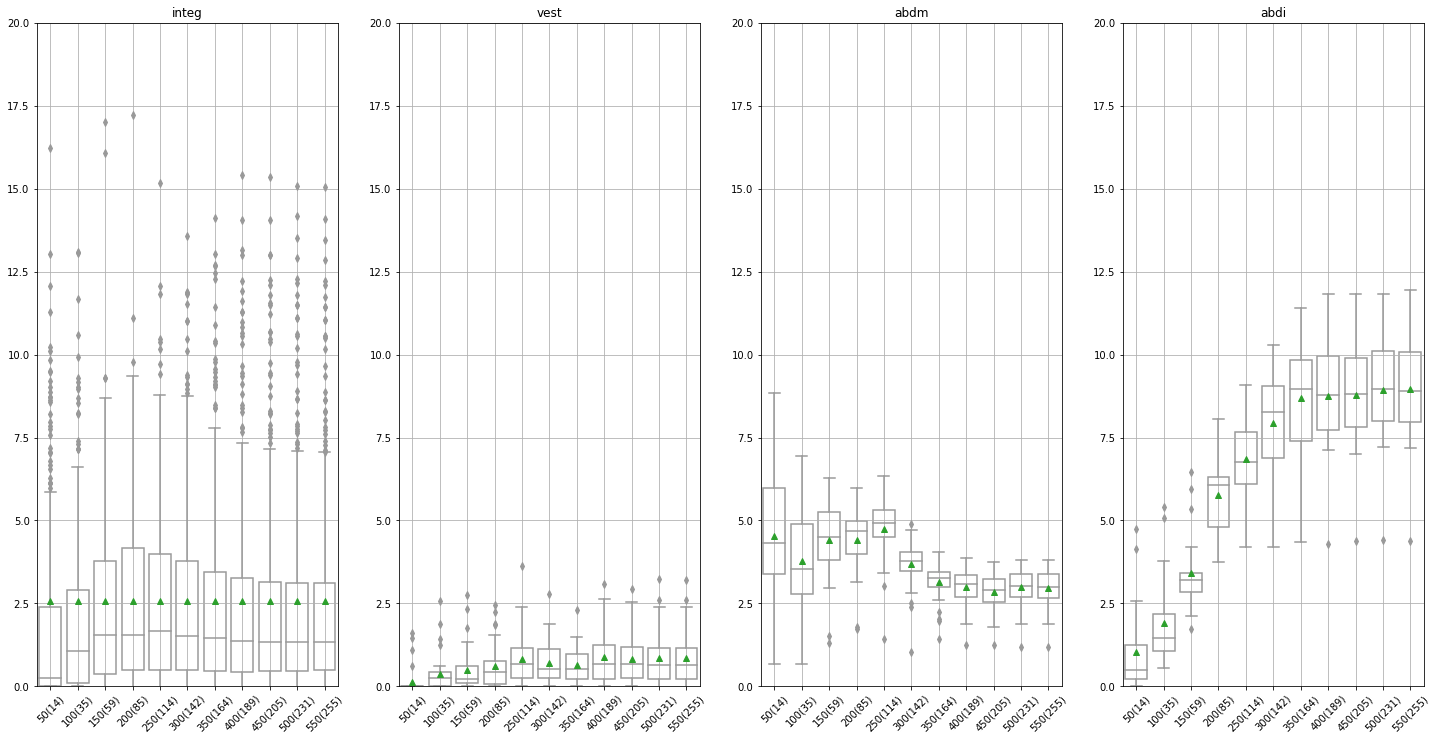

In [ ]:
plt.figure(figsize=[20,10])
plt.xlabel('Centrality cut-off')
plt.tight_layout()
plt.subplot(1,4,1)
sns.boxplot(data = [slopes_CO_top50[cdf_CO_top50.loc['integ']],
                    slopes_CO_top100[cdf_CO_top100.loc['integ']],
                    slopes_CO_top150[cdf_CO_top150.loc['integ']],
                    slopes_CO_top200[cdf_CO_top200.loc['integ']],
                    slopes_CO_top250[cdf_CO_top250.loc['integ']],
                    slopes_CO_top300[cdf_CO_top300.loc['integ']],
                    slopes_CO_top350[cdf_CO_top350.loc['integ']],
                    slopes_CO_top400[cdf_CO_top400.loc['integ']],
                    slopes_CO_top450[cdf_CO_top450.loc['integ']],
                    slopes_CO_top500[cdf_CO_top500.loc['integ']],
                    slopes_CO_top550[cdf_CO_top550.loc['integ']]],color = 'w', showmeans = True)
plt.xticks(range(0,11),labels=['50(14)','100(35)','150(59)','200(85)','250(114)','300(142)'
,'350(164)','400(189)','450(205)','500(231)','550(255)'],rotation =45)
#plt.xticks(range(0,11),labels=[16,40,65,92,121,148,171,193,211,237,260],rotation =45)

plt.grid()
plt.ylim([0,20])
plt.title('integ')

plt.subplot(1,4,2)
sns.boxplot(data = [slopes_CO_top50[cdf_CO_top50.loc['vest']],
                    slopes_CO_top100[cdf_CO_top100.loc['vest']],
                    slopes_CO_top150[cdf_CO_top150.loc['vest']],
                    slopes_CO_top200[cdf_CO_top200.loc['vest']],
                    slopes_CO_top250[cdf_CO_top250.loc['vest']],
                    slopes_CO_top300[cdf_CO_top300.loc['vest']],
                    slopes_CO_top350[cdf_CO_top350.loc['vest']],
                    slopes_CO_top400[cdf_CO_top400.loc['vest']],
                    slopes_CO_top450[cdf_CO_top450.loc['vest']],
                    slopes_CO_top500[cdf_CO_top500.loc['vest']],
                    slopes_CO_top550[cdf_CO_top550.loc['vest']]],color = 'w', showmeans = True)
plt.xticks(range(0,11),labels=['50(14)','100(35)','150(59)','200(85)','250(114)','300(142)'
,'350(164)','400(189)','450(205)','500(231)','550(255)'],rotation =45)
#plt.xticks(range(0,11),labels=[16,40,66,93,123,154,184,213,239,270,294],rotation =45)

plt.grid()
plt.ylim([0,20])
plt.title('vest')


plt.subplot(1,4,3)
sns.boxplot(data = [slopes_CO_top50[cdf_CO_top50.loc['abdm']],
                    slopes_CO_top100[cdf_CO_top100.loc['abdm']],
                    slopes_CO_top150[cdf_CO_top150.loc['abdm']],
                    slopes_CO_top200[cdf_CO_top200.loc['abdm']],
                    slopes_CO_top250[cdf_CO_top250.loc['abdm']],
                    slopes_CO_top300[cdf_CO_top300.loc['abdm']],
                    slopes_CO_top350[cdf_CO_top350.loc['abdm']],
                    slopes_CO_top400[cdf_CO_top400.loc['abdm']],
                    slopes_CO_top450[cdf_CO_top450.loc['abdm']],
                    slopes_CO_top500[cdf_CO_top500.loc['abdm']],
                    slopes_CO_top550[cdf_CO_top550.loc['abdm']]],color = 'w', showmeans = True)
plt.xticks(range(0,11),labels=['50(14)','100(35)','150(59)','200(85)','250(114)','300(142)'
,'350(164)','400(189)','450(205)','500(231)','550(255)'],rotation =45)
#plt.xticks(range(0,11),labels=[16,40,66,93,123,154,184,213,239,270,294],rotation =45)

plt.grid()
plt.ylim([0,20])
plt.title('abdm')

plt.subplot(1,4,4)
sns.boxplot(data = [slopes_CO_top50[cdf_CO_top50.loc['abdi']],
                    slopes_CO_top100[cdf_CO_top100.loc['abdi']],
                    slopes_CO_top150[cdf_CO_top150.loc['abdi']],
                    slopes_CO_top200[cdf_CO_top200.loc['abdi']],
                    slopes_CO_top250[cdf_CO_top250.loc['abdi']],
                    slopes_CO_top300[cdf_CO_top300.loc['abdi']],
                    slopes_CO_top350[cdf_CO_top350.loc['abdi']],
                    slopes_CO_top400[cdf_CO_top400.loc['abdi']],
                    slopes_CO_top450[cdf_CO_top450.loc['abdi']],
                    slopes_CO_top500[cdf_CO_top500.loc['abdi']],
                    slopes_CO_top550[cdf_CO_top550.loc['abdi']]],color = 'w', showmeans = True)
plt.xticks(range(0,11),labels=['50(14)','100(35)','150(59)','200(85)','250(114)','300(142)'
,'350(164)','400(189)','450(205)','500(231)','550(255)'],rotation =45)
#plt.xticks(range(0,11),labels=[16,40,66,93,123,154,184,213,239,270,294],rotation =45)

plt.grid()
plt.ylim([0,20])
plt.title('abdi')

plt.savefig('/content/drive/My Drive/Colab Notebooks/Kvalues/Kvalues_top50_boxplots_09222020.svg')